# How to Succeed at Speed Dating <br>Without Really Trying 

<img src="speed_dating_art.jpg" alt="Drawing" style="width: 400px; height:200px">

## Unit 3 Data Science Capstone <br> by Vincent Gomez


[Speed Dating on Kaggle](https://www.kaggle.com/annavictoria/speed-dating-experiment)  (Montoya, A. 2015)

Columbia Business School professors Ray Fisman and Sheena Iyengar.


21 experimental speed dating events from 2002-2004 

Four minute "first dates" 

<img src="Four_Minute_Timer.png"alt="Drawing" style="width: 200px">


Available Data:

Attribute Scores- Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests

Importance Scores for each attribute

Precieved Importance Scores of the opposite sex

Self-perceived scores for each attribute

Demographics- age, race, location, career field/major 

Dating habits- how often

Lifestyle information- hobbies and interests

In [65]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from matplotlib.gridspec import GridSpec
import textwrap
from sklearn import ensemble
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

%matplotlib inline

In [47]:
speed_dating_download = pd.read_csv('Speed Dating Data.csv',encoding="latin-1")

In [48]:
speed_dating = speed_dating_download.copy()

In [49]:
speed_dating2 = speed_dating_download.copy()

In [50]:
speed_dating['gender'] = speed_dating['gender'].map({0:'Female', 1:'Male'})
speed_dating['length'] = speed_dating['length'].map({1:'Too Short', 2:'Too Long', 3:'Just Right'})
speed_dating['numdat_2'] = speed_dating['numdat_2'].map({1:'Too Few', 2:'Too Many', 3:'Just Enough'})
speed_dating['race'] = speed_dating['race'].map({1:'Black', 2:'White', 3:'Latino', 4:'Asian', 5:'Native American', 6:'Other'})
speed_dating['goal'] = speed_dating['goal'].map({1:'Seemed like a fun night out', 2:'To meet new people',
                                                3:'To get a date', 4:'Looking for a serious relationship',
                                                5:'To say I did it', 6:'Other'})
# speed_dating['date_3'] = speed_dating['date_3'].map({2:0})

In [51]:
data = speed_dating.groupby(['iid']).first()

The population...

There were 551 participants.
274 women and 277 men.


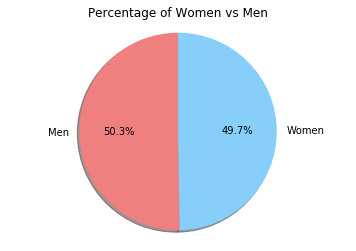

Each person met 10-20 potential matches - 4184 speed dates.


In [52]:
women_data = speed_dating[speed_dating.gender == 'Female']
men_data = speed_dating[speed_dating.gender == 'Male']

print('There were {} participants.\n{} women and {} men.'.format(speed_dating.iid.nunique(),
                                                               women_data.iid.nunique(),
                                                               men_data.iid.nunique()))
# Data to plot
labels = 'Men', 'Women'
sizes = [men_data.iid.nunique() , women_data.iid.nunique()]
colors = ['lightcoral', 'lightskyblue']
explode = ( 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes,  explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Percentage of Women vs Men')
plt.axis('equal')
plt.show()

print('Each person met 10-20 potential matches - {} speed dates.'.format(women_data.shape[0]))

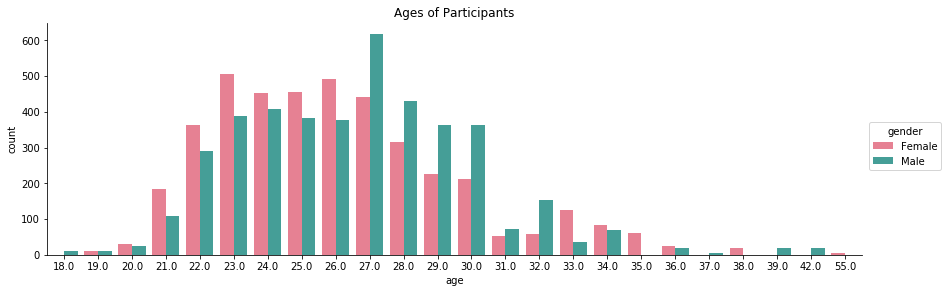

In [53]:
sns.factorplot(x="age", hue='gender', data=speed_dating, 
               kind='count',size=4, aspect=3, palette="husl")
plt.title('Ages of Participants')
plt.show()

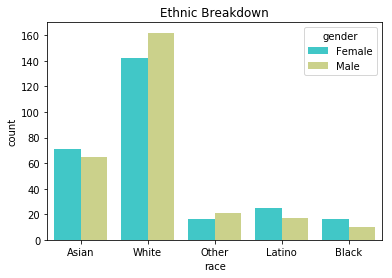

In [54]:
sns.countplot(x="race", data=data, hue='gender', palette="rainbow")
plt.title('Ethnic Breakdown')
plt.show()


There were over 200 different majors. These were the top 20 most popular ones...


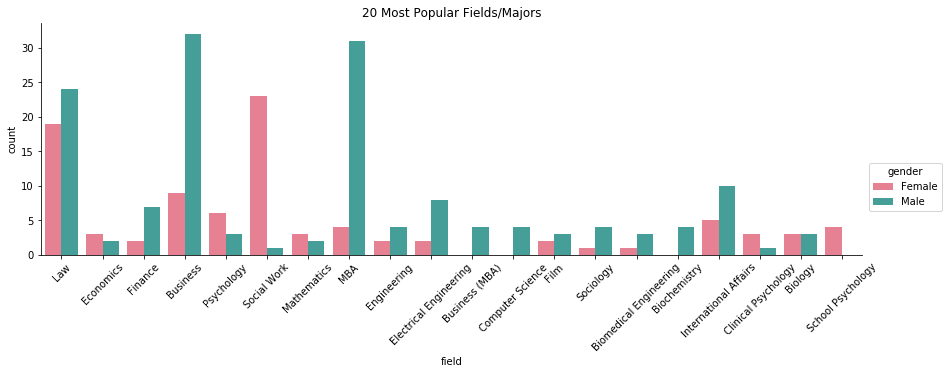

In [55]:
print("There were over 200 different majors. These were the top 20 most popular ones...")

data = speed_dating.groupby(['iid']).first()

data['field'] = data['field'].replace('business', 'Business').replace('law','Law')

top_10_fields = data.field.value_counts().head(n=20)

top_10_fields = data.loc[data.field.isin(list(top_10_fields.index)), :]

g = sns.factorplot(x="field", hue='gender', data=top_10_fields, 
               kind='count',size=4, aspect=3, palette="husl")
g.set_xticklabels(rotation=45)
plt.title('20 Most Popular Fields/Majors')
plt.show()


Key Questions:

What is the most important attribute in getting that first date?

Is there a difference in what men and women find important in a partner?

How can I make myself more 'marketable' in the dating scene?

My features:

The 6 attribute scores: Attraction, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

The overall 'like' score.

Here is how the men and women scored each other on these 6 attributes...


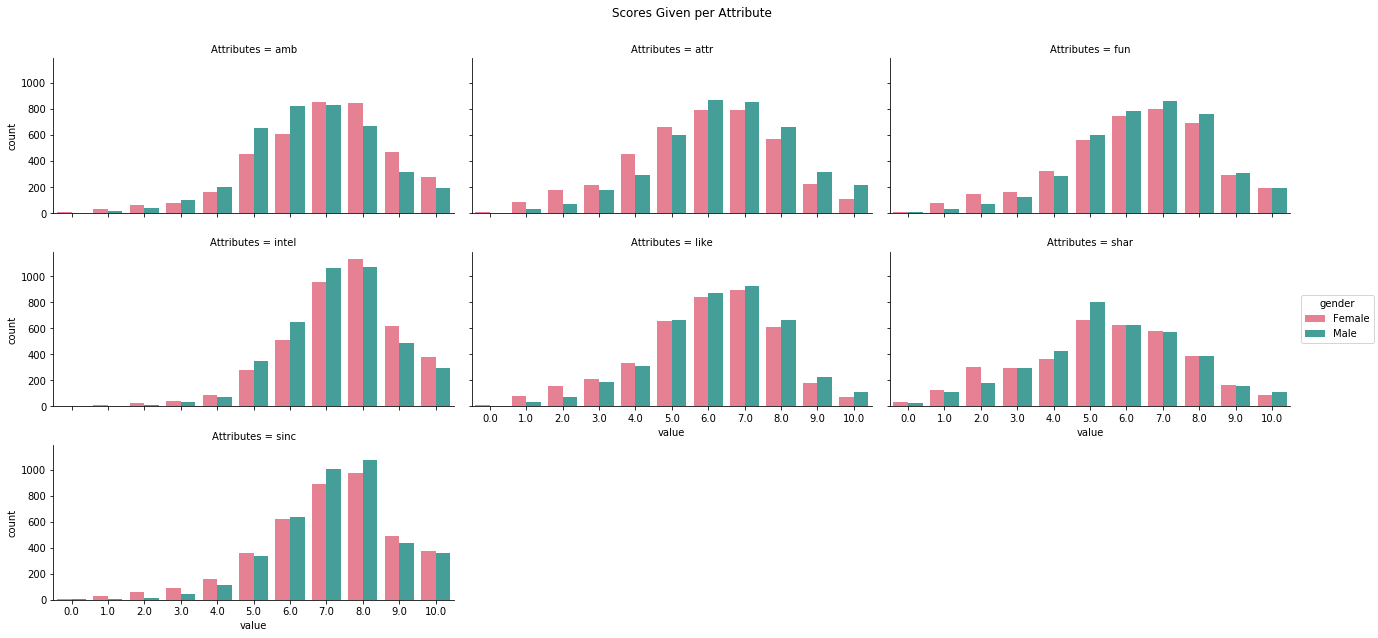

In [56]:
print('Here is how the men and women scored each other on these 6 attributes...')

experiment = speed_dating.loc[:,['iid','pid','gender', 'attr','amb','sinc','intel','fun','shar','like']]
experiment2 = pd.pivot_table(experiment,index=["iid",'gender', "pid"])
experiment2_stacked = experiment2.stack()
experiment2_stacked.index.set_names('Attributes', level=len(experiment2_stacked.index.names)-1, inplace=True)
experiment2_stacked = experiment2_stacked.reset_index().rename(columns={0:'value'})
experiment2_stacked = experiment2_stacked[experiment2_stacked['value']%1 == 0]
g = sns.factorplot(x="value", hue="gender", col="Attributes",
                   data=experiment2_stacked, kind="count",
                   size=3, aspect=2, col_wrap=3, palette='husl')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scores Given per Attribute')
plt.show()

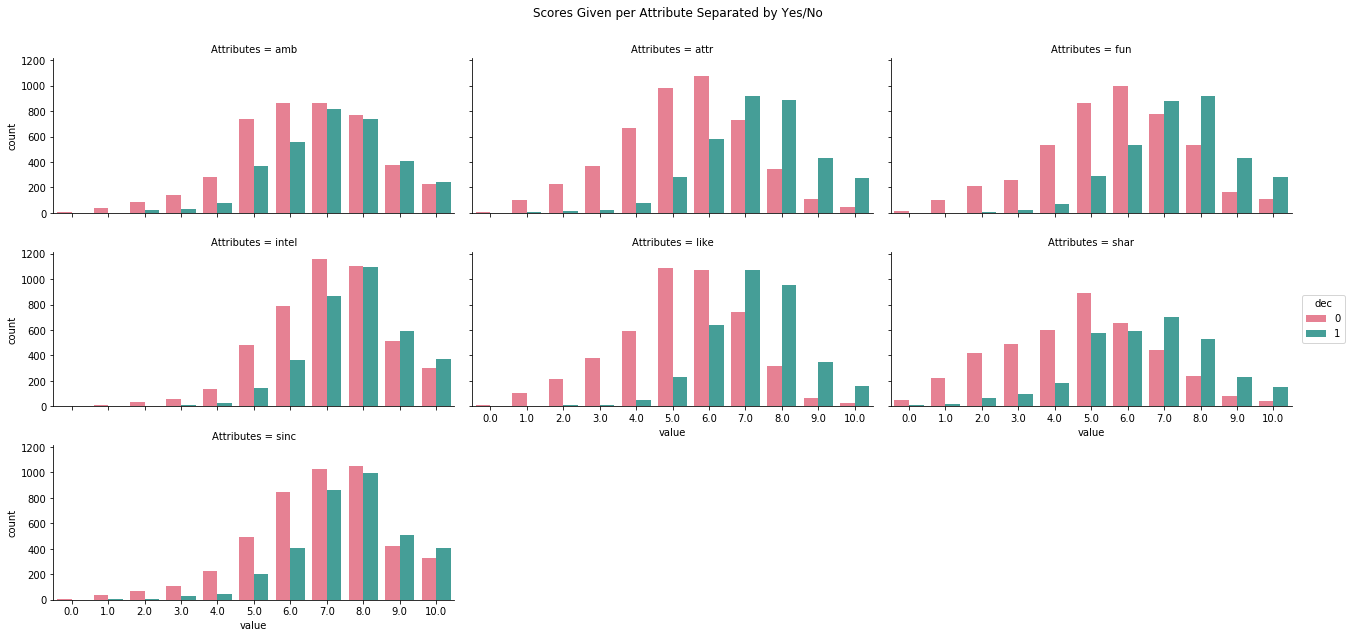

In [57]:
experiment = speed_dating.loc[:,['iid','pid','gender', 'attr','amb','sinc','intel','fun','shar','like','dec']]
experiment2 = pd.pivot_table(experiment,index=["iid",'gender', "pid",'dec'])
experiment2_stacked = experiment2.stack()
experiment2_stacked.index.set_names('Attributes', level=len(experiment2_stacked.index.names)-1, inplace=True)
experiment2_stacked = experiment2_stacked.reset_index().rename(columns={0:'value'})
experiment2_stacked = experiment2_stacked[experiment2_stacked['value']%1 == 0]
g = sns.factorplot(x="value", hue="dec", col="Attributes",
                   data=experiment2_stacked, kind="count",
                   size=3, aspect=2, col_wrap=3, palette='husl')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scores Given per Attribute Separated by Yes/No')
plt.show()

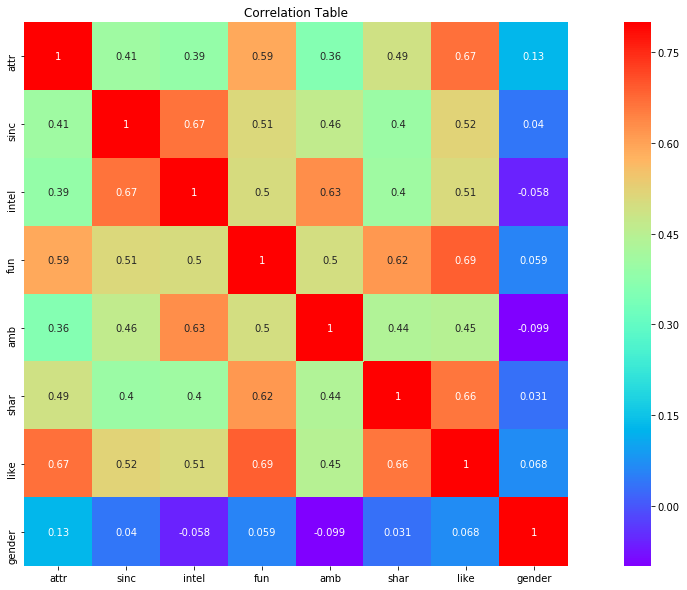

In [58]:
speed_dating1 = speed_dating2[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']].dropna()
speed_dating1_rankings = speed_dating1.corr()
plt.figure(figsize=(20,10))
sns.heatmap(speed_dating1_rankings, vmax=.8, square=True, annot=True, cmap = 'rainbow')
plt.title('Correlation Table')
plt.show()

Accuracy Result from Random Forest Classifier:
0.752136752137


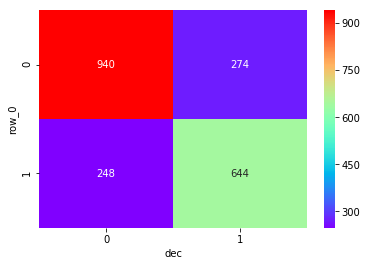

In [59]:
from sklearn.model_selection import train_test_split # to split the data into two parts

speed_dating1 = speed_dating2[['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']].dropna()
#now split our data into train and test
train, test = train_test_split(speed_dating1, test_size = 0.3)# in this our main data is splitted into train and test

print('Accuracy Result from Random Forest Classifier:')

from sklearn import metrics # for the check the error and accuracy of the model

from sklearn.ensemble import RandomForestClassifier # for random forest classifier

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']] # taking test data inputs
test_y = test.dec   #output value of test data

model=RandomForestClassifier(n_estimators=100)# a simple random forest model

model.fit(train_X,train_y)

prediction = model.predict(test_X)

print(metrics.accuracy_score(prediction,test_y))

from sklearn.metrics import confusion_matrix

sns.heatmap(pd.crosstab(prediction,test_y), annot=True, fmt="d", cmap='rainbow')
plt.show()

Decision Tree


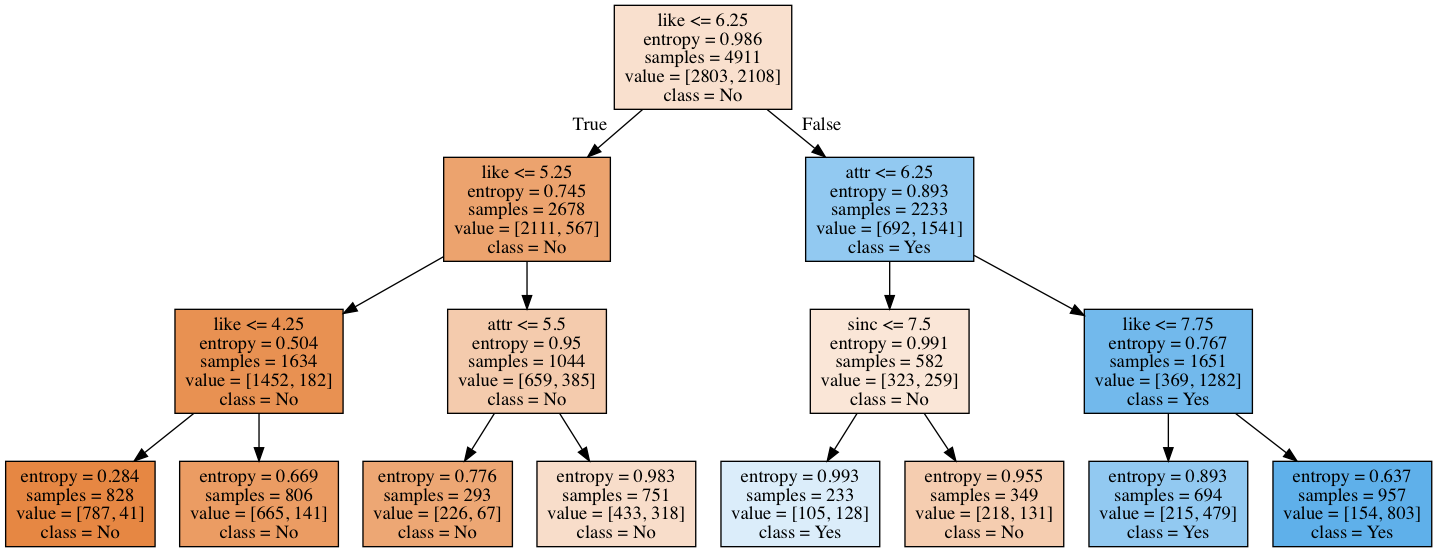

In [60]:
print('Decision Tree')

from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data
# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']] # taking test data inputs
test_y = test.dec   #output value of test data
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=3,
)
decision_tree.fit(train_X,train_y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=train_X.columns,
    class_names=['No', 'Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

List of Feature Importance based off of Gradient Boosting Classifier:


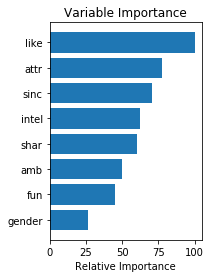

Accuracy score: 0.7711301044634378


In [61]:
print('List of Feature Importance based off of Gradient Boosting Classifier:')

from sklearn import ensemble

speed_dating2 = speed_dating_download.copy()


speed_dating1 = speed_dating2[['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']].dropna()
#now split our data into train and test

train, test = train_test_split(speed_dating1, test_size = 0.3)


train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']] # taking test data inputs
test_y = test.dec   #output value of test data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

prediction = clf.predict(test_X)
print('Accuracy score: {}'.format(metrics.accuracy_score(prediction,test_y)))

#### Regression: Beyond Yes/No
Advantages- 
-  Percentage of Yesses
-  Average Attribute scores

Disadvantages- 
-  Reduces sample size from 4,184 to 551
-  Averages are only based off of 10-20 scores 

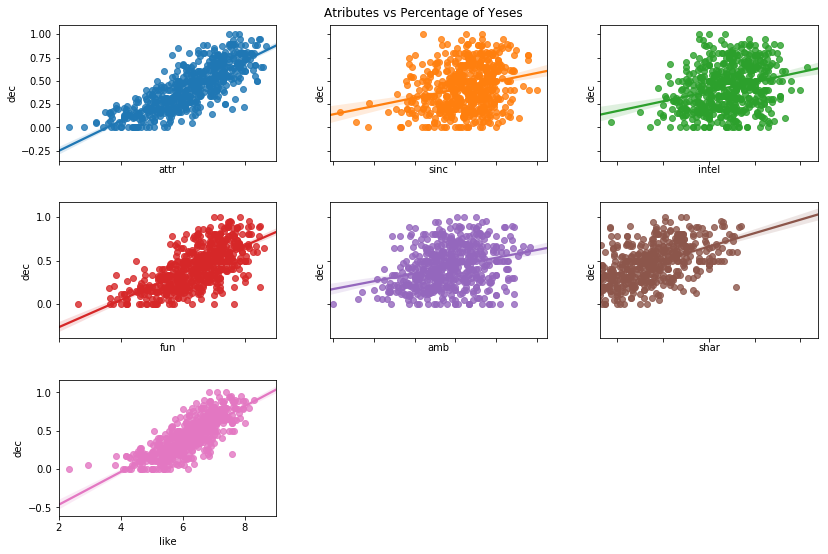

In [62]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','prob'].mean().dropna()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='col', sharey='row')
fig.tight_layout()
fig.set_size_inches(12, 8)
sns.regplot(x=score_averages.attr , y=score_averages.dec, ax=ax1)
sns.regplot(x=score_averages.sinc , y=score_averages.dec, ax=ax2)
sns.regplot(x=score_averages.intel , y=score_averages.dec, ax=ax3)
sns.regplot(x=score_averages.fun , y=score_averages.dec, ax=ax4)
sns.regplot(x=score_averages.amb , y=score_averages.dec, ax=ax5)
sns.regplot(x=score_averages.shar , y=score_averages.dec, ax=ax6)
sns.regplot(x=score_averages.like , y=score_averages.dec, ax=ax7)
fig.delaxes(ax8)
fig.delaxes(ax9)
fig.suptitle('Atributes vs Percentage of Yeses')

plt.show()

In [66]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','gender'].mean().dropna()

score_averages = score_averages.sample(frac=1)

linear_formula = 'dec ~ attr+sinc+intel+fun+amb+shar+like+gender'

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(score_averages)
x = pd.DataFrame(x)

x.columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','gender']

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=x).fit()

print('Ordinary Lease Square Regressor\nR-squared score: {}'.format(lm.rsquared))

print('\nP-values:')
print(lm.pvalues)

print('\nCoeficients:')
print(lm.params)

Ordinary Lease Square Regressor
R-squared score: 0.6950490441342894

P-values:
Intercept    4.273519e-19
attr         2.930680e-19
sinc         3.124815e-04
intel        6.650618e-01
fun          8.611022e-01
amb          7.244524e-01
shar         8.626392e-01
like         8.693716e-14
gender       2.869042e-02
dtype: float64

Coeficients:
Intercept   -0.300776
attr         0.525658
sinc        -0.204282
intel        0.029134
fun         -0.011841
amb         -0.019416
shar        -0.011532
like         0.828489
gender       0.027756
dtype: float64


Random Forest Regression R-Squared Score:
0.673162100666
Gradient Boost Regression R-Squared Score:
0.680169766694


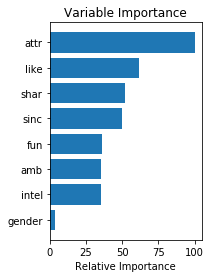

In [67]:
from sklearn.ensemble import RandomForestRegressor

speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','gender'].mean().dropna()

score_averages = score_averages.sample(frac=1)
# y = score_averages.dec.values.reshape(-1, 1)
# x = score_averages[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]

train, test = train_test_split(score_averages, test_size = 0.3)

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data
# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']] # taking test data inputs
test_y = test.dec   #output value of test data



regr_rf = RandomForestRegressor(max_depth=4, random_state=2)
regr_rf.fit(train_X, train_y)

print('Random Forest Regression R-Squared Score:')
print(regr_rf.score(test_X, test_y))

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(train_X, train_y)

feature_importance = clf.feature_importances_

print('Gradient Boost Regression R-Squared Score:')
print(clf.score(test_X, test_y))

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

A regression with this Data Set doesn't seem like a good idea... 

Adding more features...

1\) Self Ratings

2\) Attribute Importance Ratings

On the day of the event, these are the results:


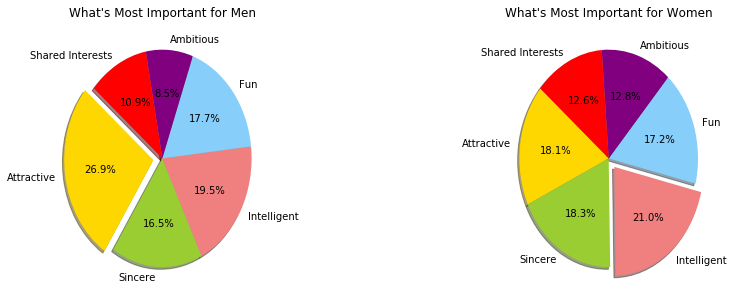

In [68]:
print('On the day of the event, these are the results:')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))

attr_sum = men_data.attr1_1.sum()
sinc_sum = men_data.sinc1_1.sum()
intell_sum = men_data.intel1_1.sum()
fun_sum = men_data.fun1_1.sum()
amb_sum = men_data.amb1_1.sum()
shar_sum = men_data.shar1_1.sum()

# Data to plot
labels = 'Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious', 'Shared Interests'
sizes = [attr_sum, sinc_sum, intell_sum, fun_sum, amb_sum, shar_sum]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'purple', 'red']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
ax1.pie(sizes,  explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title('What\'s Most Important for Men')
 
# plt.axis('equal')

attr_sum = women_data.attr1_1.sum()
sinc_sum = women_data.sinc1_1.sum()
intell_sum = women_data.intel1_1.sum()
fun_sum = women_data.fun1_1.sum()
amb_sum = women_data.amb1_1.sum()
shar_sum = women_data.shar1_1.sum()

# Data to plot
labels = 'Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious', 'Shared Interests'
sizes = [attr_sum, sinc_sum, intell_sum, fun_sum, amb_sum, shar_sum]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'purple', 'red']
explode = (0, 0, 0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
ax2.pie(sizes,  explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
ax2.set_title('What\'s Most Important for Women')
 
# plt.axis('equal')
fig.subplots_adjust(wspace=1)
plt.show()

When asked in the days following the event, however, there were a few changes...


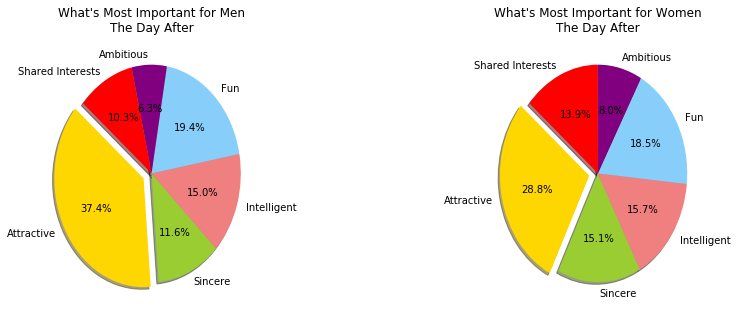

In [69]:
print('When asked in the days following the event, however, there were a few changes...')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))

attr_sum = men_data.attr7_2.sum()
sinc_sum = men_data.sinc7_2.sum()
intell_sum = men_data.intel7_2.sum()
fun_sum = men_data.fun7_2.sum()
amb_sum = men_data.amb7_2.sum()
shar_sum = men_data.shar7_2.sum()


# Data to plot
labels = 'Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious', 'Shared Interests'
sizes = [attr_sum, sinc_sum, intell_sum, fun_sum, amb_sum, shar_sum]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'purple', 'red']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
ax1.pie(sizes,  explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title('What\'s Most Important for Men\nThe Day After')
 
# plt.axis('equal')

attr_sum = women_data.attr7_2.sum()
sinc_sum = women_data.sinc7_2.sum()
intell_sum = women_data.intel7_2.sum()
fun_sum = women_data.fun7_2.sum()
amb_sum = women_data.amb7_2.sum()
shar_sum = women_data.shar7_2.sum()

# Data to plot
labels = 'Attractive', 'Sincere', 'Intelligent', 'Fun', 'Ambitious', 'Shared Interests'
sizes = [attr_sum, sinc_sum, intell_sum, fun_sum, amb_sum, shar_sum]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'purple', 'red']
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
 
# Plot
ax2.pie(sizes,  explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
ax2.set_title('What\'s Most Important for Women\nThe Day After')
 
# plt.axis('equal')
fig.subplots_adjust(wspace=1)
plt.show()

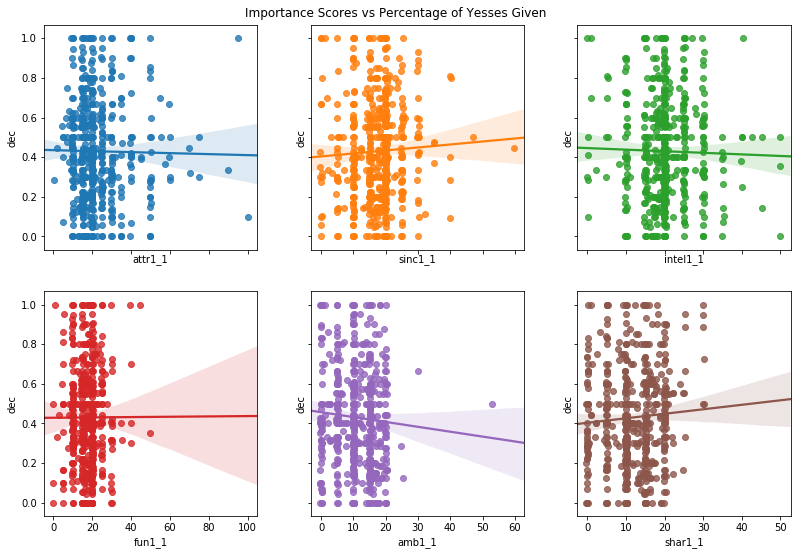

In [70]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['iid'])['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1','shar1_1','dec'].mean().dropna()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
fig.tight_layout()
fig.set_size_inches(12, 8)
sns.regplot(x=score_averages.attr1_1 , y=score_averages.dec,x_jitter=0.3, ax=ax1)
sns.regplot(x=score_averages.sinc1_1 , y=score_averages.dec,x_jitter=0.3, ax=ax2)
sns.regplot(x=score_averages.intel1_1 , y=score_averages.dec,x_jitter=0.3, ax=ax3)
sns.regplot(x=score_averages.fun1_1 , y=score_averages.dec,x_jitter=0.3, ax=ax4)
sns.regplot(x=score_averages.amb1_1 , y=score_averages.dec,x_jitter=0.3, ax=ax5)
sns.regplot(x=score_averages.shar1_1 , y=score_averages.dec,x_jitter=0.3, ax=ax6)
fig.suptitle('Importance Scores vs Percentage of Yesses Given')

plt.show()

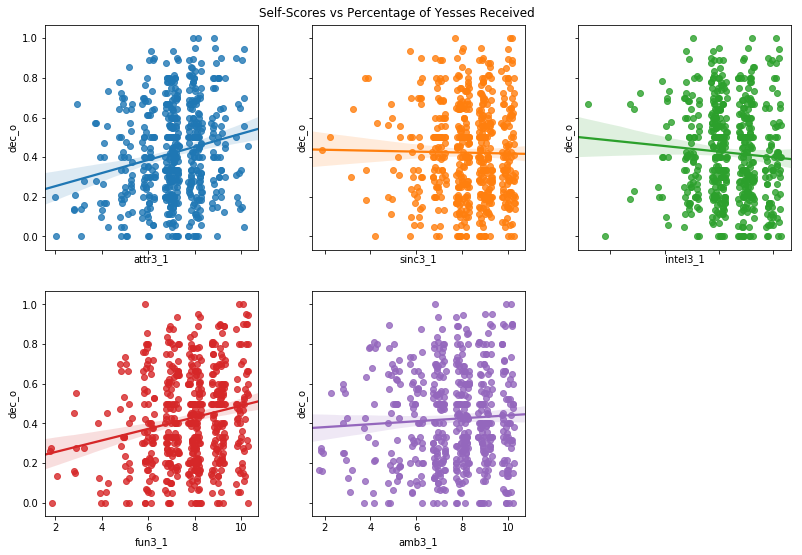

In [71]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['iid'])['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1','dec_o'].mean().dropna()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
fig.tight_layout()
fig.set_size_inches(12, 8)
sns.regplot(x=score_averages.attr3_1 , y=score_averages.dec_o,x_jitter=0.3, ax=ax1)
sns.regplot(x=score_averages.sinc3_1 , y=score_averages.dec_o,x_jitter=0.3, ax=ax2)
sns.regplot(x=score_averages.intel3_1 , y=score_averages.dec_o,x_jitter=0.3, ax=ax3)
sns.regplot(x=score_averages.fun3_1 , y=score_averages.dec_o,x_jitter=0.3, ax=ax4)
sns.regplot(x=score_averages.amb3_1 , y=score_averages.dec_o,x_jitter=0.3, ax=ax5)
plt.delaxes(ax6)
fig.suptitle('Self-Scores vs Percentage of Yesses Received')

plt.show()

In [72]:
self_scores = data.loc[:,['gender', 'attr3_1',
                                 'amb3_1','sinc3_1','intel3_1',
                                 'fun3_1']]
self_scores.columns = ['gender', 'attr','amb','sinc','intel','fun']
self_scores_pivot = pd.pivot_table(self_scores,index=["iid",'gender'])
self_scores_stacked = self_scores_pivot.stack()
self_scores_stacked.index.set_names('Attributes', level=len(self_scores_stacked.index.names)-1, inplace=True)
self_scores_stacked = self_scores_stacked.reset_index().rename(columns={0:'Self_Scores'})
self_scores_stacked.head()

,iid,gender,Attributes,Self_Scores
0,1,Female,amb,7.0
1,1,Female,attr,6.0
2,1,Female,fun,8.0
3,1,Female,intel,8.0
4,1,Female,sinc,8.0


In [73]:
score_averages = speed_dating.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'dec','gender'].mean()
score_averages_pivot = pd.pivot_table(score_averages,index=["pid",'dec'])
score_averages_stacked = score_averages_pivot.stack()
score_averages_stacked.index.set_names('Attributes', level=len(score_averages_stacked.index.names)-1, inplace=True)
score_averages_stacked = score_averages_stacked.reset_index().rename(columns={0:'Given_Scores'})
score_averages_stacked.columns = ['iid', 'dec','Attributes','Given_Scores']
score_averages_stacked.head()

,iid,dec,Attributes,Given_Scores
0,1.0,0.5,amb,8.0
1,1.0,0.5,attr,6.7
2,1.0,0.5,fun,7.2
3,1.0,0.5,intel,8.0
4,1.0,0.5,sinc,7.4


In [74]:
self_and_given_scores = pd.merge(self_scores_stacked, score_averages_stacked, how='inner', on=['iid','Attributes'], left_on=None, right_on=None,
         left_index=True, right_index=True)
self_and_given_scores.head()

,iid,gender,Attributes,Self_Scores,dec,Given_Scores
0,1,Female,amb,7.0,0.5,8.0
1,1,Female,attr,6.0,0.5,6.7
2,1,Female,fun,8.0,0.5,7.2
3,1,Female,intel,8.0,0.5,8.0
4,1,Female,sinc,8.0,0.5,7.4


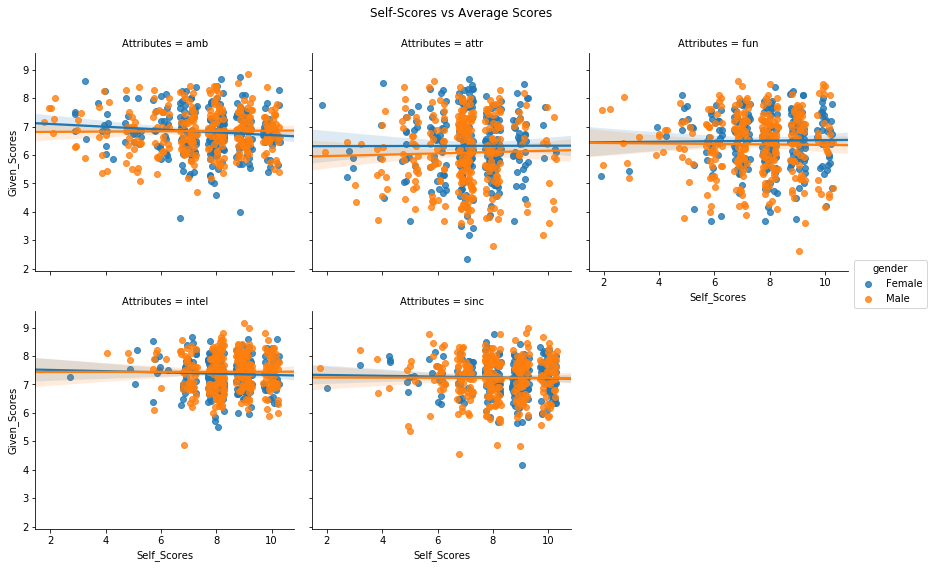

In [75]:
g = sns.lmplot(x="Self_Scores", y="Given_Scores", data=self_and_given_scores, hue='gender',
           col='Attributes',col_wrap=3, x_jitter=.3, size=4, aspect=1)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Self-Scores vs Average Scores')
plt.show()

In [76]:
print('Gradient Boosting Classifiers\n')
speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec_o','attr3_1','amb3_1','sinc3_1','intel3_1',
                               'fun3_1','gender']].dropna()

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
train_y= train.dec_o# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
test_y= test.dec_o# This is output of our training data

pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Your Partner\'s Self-scores to predict giving a Yes or No:')
print("Percent Accuracy = {}\n".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))


speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'prob','attr1_1','amb1_1','sinc1_1','intel1_1',
                               'fun1_1','shar1_1','gender']].dropna()

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1','shar1_1','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1','shar1_1','gender']]# taking the training data input 
test_y= test.dec# This is output of our training data



pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Personal Attribute Importance scores to predict giving a Yes or No:')
print("Percent Accuracy = {}\n".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))

speed_dating2 = speed_dating_download.copy()


speed_dating1 = speed_dating2[['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']].dropna()
#now split our data into train and test

train, test = train_test_split(speed_dating1, test_size = 0.3)


train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']] # taking test data inputs
test_y = test.dec   #output value of test data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

prediction = clf.predict(test_X)
print('Using Attribute Scores to predict giving a Yes or No:\nPercent Accuracy: {}\n'.format(metrics.accuracy_score(prediction,test_y)))

Gradient Boosting Classifiers

Using Your Partner's Self-scores to predict giving a Yes or No:
Percent Accuracy = 0.5946817082997583

Using Personal Attribute Importance scores to predict giving a Yes or No:
Percent Accuracy = 0.6335845896147404

Using Attribute Scores to predict giving a Yes or No:
Percent Accuracy: 0.7706552706552706



Random Forrest Classifier Accuracy = 0.8128054740957967
Gradient Boosting Classifier Accuracy = 0.8137829912023461


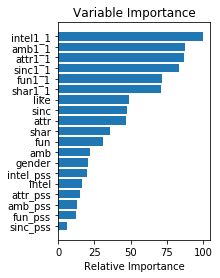

1_1 - Attribute Importance
_pss - Partner's Self Score


In [98]:
speed_dating2 = speed_dating_download.copy()

self_scores = speed_dating2[['iid','pid','attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']]
speed_to_merge = speed_dating2[['iid','pid','attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1',
                                'shar1_1', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
                                'dec','gender']]
self_scores.columns = ['pid', 'iid','attr_pss','sinc_pss','intel_pss','fun_pss','amb_pss']
self_scores.head()

merged =  pd.merge(self_scores, speed_to_merge, on=['iid', 'pid'])
merged = merged.dropna()

speed_dating2 = merged.sample(frac=1)

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
                 'attr_pss','sinc_pss','intel_pss','fun_pss','amb_pss','attr1_1',
                 'amb1_1','sinc1_1','intel1_1','fun1_1','shar1_1','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
                 'attr_pss','sinc_pss','intel_pss','fun_pss','amb_pss',
               'attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1',
               'shar1_1','gender']]# taking the training data input 
test_y = test.dec# This is output of our training data



model=RandomForestClassifier(n_estimators=100)# a simple random forest model

model.fit(train_X,train_y)

prediction = model.predict(test_X)

print('Random Forrest Classifier Accuracy = {}'.format(metrics.accuracy_score(prediction,test_y)))

pred_y = clf.predict(test_X)

# Accuracy table.
# table = pd.crosstab(test_y, pred_y)

print("Gradient Boosting Classifier Accuracy = {}".format(metrics.accuracy_score(pred_y,test_y)))


feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

print('1_1 - Attribute Importance\n_pss - Partner\'s Self Score')

Conclusion: 
- There isn't much you can do to make yourself more 'marketable'.
- The best you can do is to be as aware as possible of when somebody else authentically likes you and just go from there.

Ideas for Future Models:

- Race- Paper already written by Fisher and Iyengar in [Racial Preferences in Dating](http://faculty.chicagobooth.edu/emir.kamenica/documents/racialpreferences.pdf)
- Dating Habits
- Financial Status
- Location
- Age differences

References

Fisher, R. & Iyengar, S. (2004). Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment \[Data file and code book\]. Retrieved from http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/

Montoya, A. (2015). Speed Dating Experiment
What attributes influence the selection of a romantic partner?. Retrieved from https://www.kaggle.com/annavictoria/speed-dating-experiment

And here is how they scored themselves...


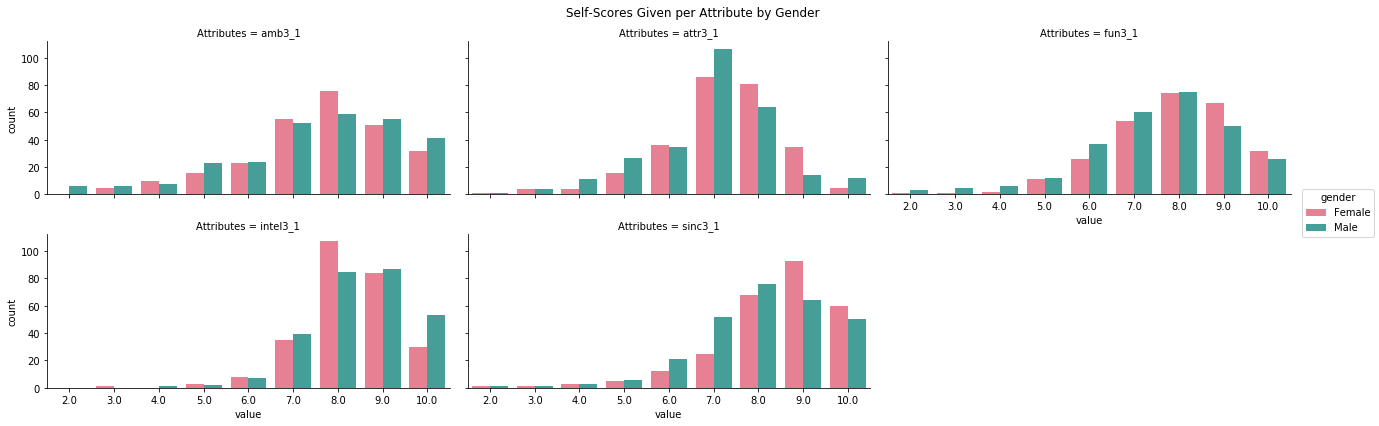

In [78]:
print('And here is how they scored themselves...')

experiment = speed_dating.loc[:,['iid','pid','gender', 'attr3_1',
                                 'amb3_1','sinc3_1','intel3_1',
                                 'fun3_1']]
experiment = experiment.groupby(['iid']).first()
experiment2 = pd.pivot_table(experiment,index=["iid",'gender', "pid"])
experiment2_stacked = experiment2.stack()
experiment2_stacked.index.set_names('Attributes', level=len(experiment2_stacked.index.names)-1, inplace=True)
experiment2_stacked = experiment2_stacked.reset_index().rename(columns={0:'value'})
experiment2_stacked = experiment2_stacked[experiment2_stacked['value']%1 == 0]
g = sns.factorplot(x="value", hue="gender", col="Attributes",
                   data=experiment2_stacked, kind="count",
                   size=3, aspect=2, col_wrap=3, palette='husl')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Self-Scores Given per Attribute by Gender')
plt.show()

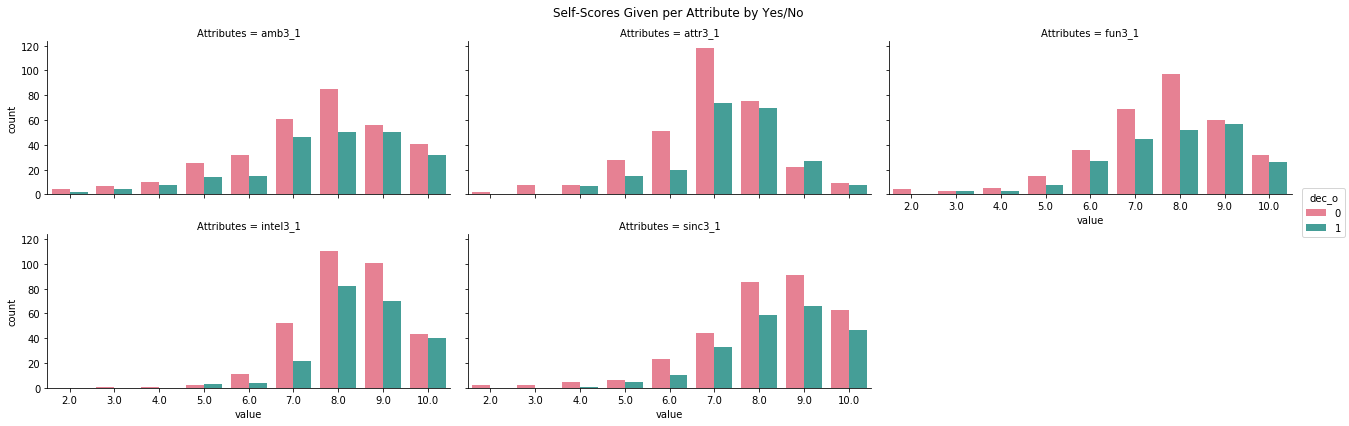

In [79]:
experiment = speed_dating.loc[:,['iid','pid','gender', 'attr3_1',
                                 'amb3_1','sinc3_1','intel3_1',
                                 'fun3_1','dec_o']]
experiment = experiment.groupby(['iid']).first()
experiment2 = pd.pivot_table(experiment,index=["iid",'gender', "pid",'dec_o'])
experiment2_stacked = experiment2.stack()
experiment2_stacked.index.set_names('Attributes', level=len(experiment2_stacked.index.names)-1, inplace=True)
experiment2_stacked = experiment2_stacked.reset_index().rename(columns={0:'value'})
experiment2_stacked = experiment2_stacked[experiment2_stacked['value']%1 == 0]
g = sns.factorplot(x="value", hue="dec_o", col="Attributes",
                   data=experiment2_stacked, kind="count",
                   size=3, aspect=2, col_wrap=3, palette='husl')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Self-Scores Given per Attribute by Yes/No')
plt.show()

Gradient Boosting Classifier Accuracy = 0.8116222760290557
Random Forrest Classifier Accuracy = 0.826634382566586


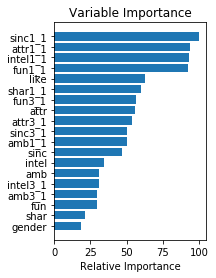

7_2 - Attribute Importance
3_1 - Self Score


In [80]:


speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
                               'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1',
                              'attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1',
                               'shar1_1','gender']].dropna()

score_averages2 = score_averages2.sample(frac=1)

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
                 'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','attr1_1',
                 'amb1_1','sinc1_1','intel1_1','fun1_1','shar1_1','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
                 'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1',
               'attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1',
               'shar1_1','gender']]# taking the training data input 
test_y = test.dec# This is output of our training data


pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print("Gradient Boosting Classifier Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))

model=RandomForestClassifier(n_estimators=100)# a simple random forest model

model.fit(train_X,train_y)

prediction = model.predict(test_X)

print('Random Forrest Classifier Accuracy = {}'.format(metrics.accuracy_score(prediction,test_y)))

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

print('7_2 - Attribute Importance\n3_1 - Self Score')

Gradient Boosting Classifier Accuracy = 0.7983539094650206
Random Forrest Classifier Accuracy = 0.8127572016460906


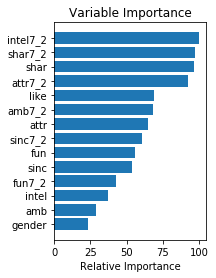

7_2 - Attribute Importance
3_1 - Self Score


In [81]:
from sklearn import ensemble

speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
                              "attr7_2", 'sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2', 
                               'shar7_2','gender']].dropna()

speed_dating2 = speed_dating2.sample(frac=1)

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
                 "attr7_2", 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2','shar7_2','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', "attr7_2", 'sinc7_2', 
                 'intel7_2', 'fun7_2', 'amb7_2','shar7_2','gender']]# taking the training data input 
test_y = test.dec# This is output of our training data


pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print("Gradient Boosting Classifier Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))

model=RandomForestClassifier(n_estimators=100)# a simple random forest model

model.fit(train_X,train_y)

prediction = model.predict(test_X)

print('Random Forrest Classifier Accuracy = {}'.format(metrics.accuracy_score(prediction,test_y)))

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

print('7_2 - Attribute Importance\n3_1 - Self Score')

Gradient Boosting Classifier Accuracy = 0.7862301396244583
Random Forrest Classifier Accuracy = 0.79826673086182


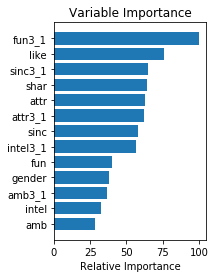

7_2 - Attribute Importance
3_1 - Self Score


In [82]:
speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
                               'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1',
                              'gender']].dropna()

score_averages2 = score_averages2.sample(frac=1)

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
                 'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
                 'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
test_y = test.dec# This is output of our training data


pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print("Gradient Boosting Classifier Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))

model=RandomForestClassifier(n_estimators=100)# a simple random forest model

model.fit(train_X,train_y)

prediction = model.predict(test_X)

print('Random Forrest Classifier Accuracy = {}'.format(metrics.accuracy_score(prediction,test_y)))

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

print('7_2 - Attribute Importance\n3_1 - Self Score')

In [83]:
# test_X = test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 
#                  'attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1',"attr7_2", 'sinc7_2', 
#                  'intel7_2', 'fun7_2', 'amb7_2','shar7_2','gender']]# taking the training data input 
# test_y = test.dec# This is output of our training data


# pred_y = clf.predict(test_X)

# # Accuracy table.
# table = pd.crosstab(test_y, pred_y)

# print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))
# sns.heatmap(table, annot=True, fmt="d", cmap='rainbow')
# plt.show()

0.799229658161


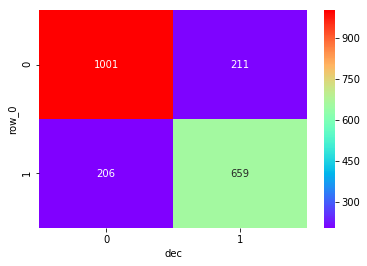

In [84]:
model=RandomForestClassifier(n_estimators=100)# a simple random forest model

model.fit(train_X,train_y)

prediction = model.predict(test_X)

print(metrics.accuracy_score(prediction,test_y))

from sklearn.metrics import confusion_matrix

sns.heatmap(pd.crosstab(prediction,test_y), annot=True, fmt="d", cmap='rainbow')
plt.show()

In [85]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
                                                 'like', 'dec','prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender'].mean().dropna()

linear_formula = 'dec ~ attr+sinc+intel+fun+amb+shar+like+gender+prob+attr3_1+amb3_1+sinc3_1+intel3_1+fun3_1+attr7_2+sinc7_2+intel7_2+fun7_2+amb7_2+shar7_2'

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(score_averages)
x = pd.DataFrame(x)

x.columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
            'like', 'dec','prob','attr3_1','amb3_1',
            'sinc3_1','intel3_1','fun3_1',"attr7_2", 
            'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
            'shar7_2','gender']

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=x).fit()

print(lm.pvalues.loc[lm.pvalues < .05])
print(lm.pvalues.loc[lm.pvalues >= .05])
print(lm.rsquared)
print(lm.params.loc[abs(lm.params) >= .1])
print(lm.params.loc[~(abs(lm.params) >= .1)])

attr       2.144207e-07
sinc       1.751018e-02
like       3.138141e-05
amb3_1     1.877713e-04
sinc3_1    3.261634e-03
sinc7_2    8.726914e-03
amb7_2     1.132520e-04
shar7_2    1.400879e-02
dtype: float64
Intercept    0.225993
intel        0.754258
fun          0.413168
amb          0.161587
shar         0.536391
gender       0.480581
prob         0.105509
attr3_1      0.314501
intel3_1     0.278765
fun3_1       0.139510
attr7_2      0.188012
intel7_2     0.756531
fun7_2       0.989565
dtype: float64
0.768075138434
Intercept   -0.424095
attr         0.457728
sinc        -0.224119
amb          0.130126
like         0.683571
prob         0.127370
attr3_1      0.177958
amb3_1       0.780899
sinc3_1     -0.592760
intel3_1    -0.109370
fun3_1      -0.260764
attr7_2     -0.160890
sinc7_2     -0.236776
amb7_2      -0.444820
shar7_2      0.746500
dtype: float64
intel       0.036405
fun        -0.071639
shar        0.061174
gender     -0.046860
intel7_2    0.028821
fun7_2      0.001103
dtype:

In [86]:
speed_dating2 = speed_dating_download.copy()
score_averages2 = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
                                                 'like', 'dec','prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender'].mean().dropna()

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(score_averages2)
x = pd.DataFrame(x)

x.columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
            'like', 'dec','prob','attr3_1','amb3_1',
            'sinc3_1','intel3_1','fun3_1',"attr7_2", 
            'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
            'shar7_2','gender']

train, test = train_test_split(x, test_size = 0.3)

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data
# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender']] # taking test data inputs
test_y = test.dec   #output value of test data

# Small number of parameters.
lass = linear_model.Lasso(alpha=.0007)
lassfit = lass.fit(train_X, train_y)
print('R² for the model with few features:')
print(lass.score(train_X, train_y))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')

features = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender','intercept']
# print(origparams)
for num in range(len(origparams)):
    print('{} : {}'.format(features[num], origparams[num]))

R² for the model with few features:
0.782621299143

Parameter estimates for the model with few features:
attr : 0.4741179440852613
sinc : -0.19726358783487008
intel : 0.035565425417849655
fun : 0.0051810712692547
amb : 0.05826169580613789
shar : 0.15456177390651288
like : 0.5352357262620783
prob : 0.13367133655304414
attr3_1 : -0.0019401554515462692
amb3_1 : 0.058874147440864215
sinc3_1 : -0.135420643838096
intel3_1 : 0.0
fun3_1 : -0.12216411465632317
attr7_2 : 0.0
sinc7_2 : -0.04908341260023108
intel7_2 : -0.09435568801592595
fun7_2 : -0.05845488080573005
amb7_2 : -0.12821555553922248
shar7_2 : 0.0
gender : -0.09614811951246116
intercept : -0.005415111938312567


In [87]:
speed_dating2 = speed_dating_download.copy()
score_averages2 = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
                                                 'like', 'dec','prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender'].mean().dropna()

score_averages2 = score_averages2.sample(frac=1)

train, test = train_test_split(score_averages2, test_size = 0.3)

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender']]# taking the training data input 
train_y= train.dec.values.reshape(-1, 1) # This is output of our training data
# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender']] # taking test data inputs
test_y = test.dec   #output value of test data



# y = score_averages.dec.values.reshape(-1, 1)
# x = score_averages[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','prob']]

regr_rf = RandomForestRegressor(max_depth=4, random_state=2)
regr_rf.fit(train_X, train_y)

print('Random Forest Regression R-Squared Score:')
print(regr_rf.score(test_X, test_y))

Random Forest Regression R-Squared Score:
0.56587889956


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


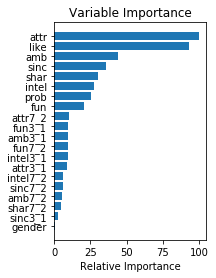

In [88]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(train_X, train_y)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Here are the raw numbers of YES's and NO's given...


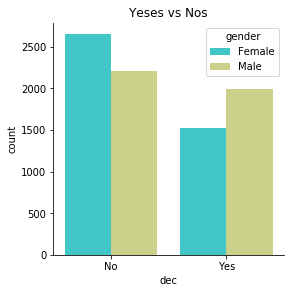

In [89]:
print('Here are the raw numbers of YES\'s and NO\'s given...')

g = sns.factorplot(x="dec", hue='gender', data=speed_dating, 
               kind='count', palette="rainbow", legend_out = False)

plt.title('Yeses vs Nos')

g.set_xticklabels(['No','Yes'])

plt.show()

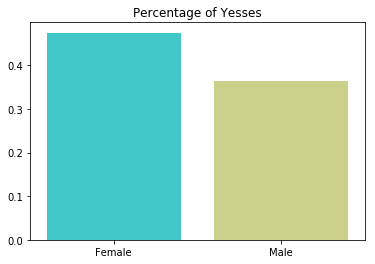

Women had a 47.5% chance of getting a yes while men had a 36.5% chance.


In [90]:
men_percent = speed_dating.loc[(speed_dating.gender == 'Male'), :].dec_o.mean()
women_percent = speed_dating.loc[(speed_dating.gender == 'Female') , :].dec_o.mean()

gender_yes_averages = [women_percent, men_percent]
genders = ['Female','Male']

sns.barplot(x=genders, y=gender_yes_averages, palette = 'rainbow')

plt.title('Percentage of Yesses')

plt.show()

print('Women had a {:.1%} chance of getting a yes while men had a {:.1%} chance.'.format(women_percent, men_percent))


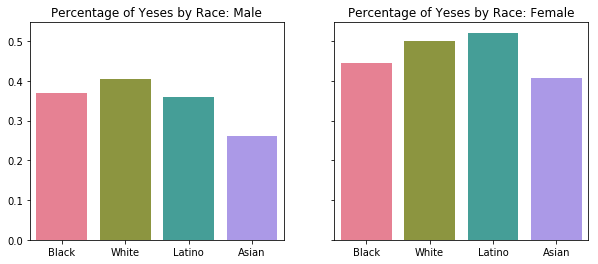

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4), sharey=True)

races = ['Black', 'White', 'Latino', 'Asian']
ethnicity_yes_average = []
for race in races:
    ethnicity_yes_average.append(speed_dating.loc[((speed_dating.gender == 'Male') & (speed_dating.race == race)), :].dec_o.mean())

sns.barplot(x=races, y=ethnicity_yes_average, ax=ax1, palette='husl')
ax1.set_title('Percentage of Yeses by Race: Male')

races = ['Black', 'White', 'Latino', 'Asian']
ethnicity_yes_average = []
for race in races:
    ethnicity_yes_average.append(speed_dating.loc[((speed_dating.gender == 'Female') & (speed_dating.race == race)), :].dec_o.mean())

sns.barplot(x=races, y=ethnicity_yes_average, ax=ax2, palette='husl')
ax2.set_title('Percentage of Yeses by Race: Female')
plt.show()

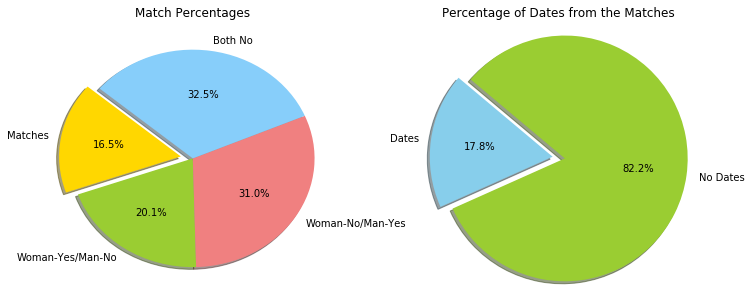

In [92]:
total = women_data.shape[0]
matches = women_data.loc[((women_data.dec_o == 1) & (women_data.dec == 1)),:].shape[0]

womanY_manN = women_data.loc[((women_data.dec_o == 0) & (women_data.dec == 1)),:].shape[0]

womanN_manY = women_data.loc[((women_data.dec_o == 1) & (women_data.dec == 0)),:].shape[0]

bothN = women_data.loc[((women_data.dec_o == 0) & (women_data.dec == 0)),:].shape[0]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
# Data to plot
labels = 'Matches', 'Woman-Yes/Man-No', 'Woman-No/Man-Yes', 'Both No'
sizes = [matches, womanY_manN, womanN_manY, bothN]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
ax1.pie(sizes,  explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

ax1.set_title('Match Percentages')
plt.axis('equal')

ax2.pie([17.8,82.2],  explode=[0.1,0], labels=['Dates', 'No Dates'], colors=['skyblue', 'yellowgreen'],
        autopct='%1.1f%%', shadow=True, startangle=140)

ax2.set_title('Percentage of Dates from the Matches')
plt.axis('equal')

# fig.subplots_adjust(wspace=1)

plt.show()

Only 3% of the speed dates resulted in actual dates!


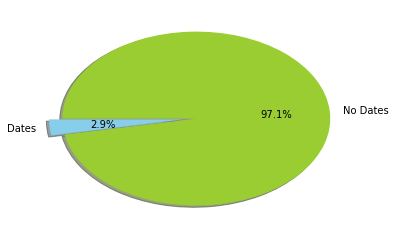

In [93]:
print("Only 3% of the speed dates resulted in actual dates!")

plt.pie([0.02937,0.97063],  explode=[0.1,0], labels=['Dates', 'No Dates'], colors=['skyblue', 'yellowgreen'],
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.show()

Creating Predictive Models

Selecting Features

In [95]:


# speed_dating2 = speed_dating_download.copy()
# score_averages = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','prob'].mean().dropna()

# x = score_averages.attr.reshape(-1, 1)
# y = score_averages.dec.reshape(-1, 1)

# x_constant = sm.add_constant(x)

# ols = sm.OLS(y, x_constant)
# ols_result = ols.fit()
# # Now you have at your disposition several error estimates, e.g.
# # print(ols_result.HC0_se)
# # and covariance estimates
# # print(ols_result.cov_HC0)

# ols_result.summary()

NameError: name 'ols' is not defined

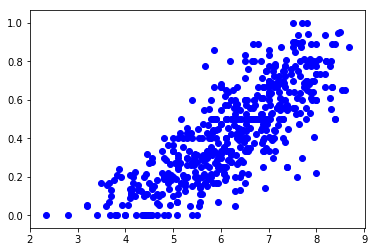

In [96]:
# plt.scatter(x, y, color='blue')
# plt.plot(x, ols.predict(ols_result.params), color='black', linewidth=1)

# plt.errorbar(x, ols.predict(ols_result.params), yerr= .152, color='pink', alpha=0.3)
# plt.show()

In [97]:
# from sklearn.linear_model import LogisticRegression

# # train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']]# taking the training data input 
# # train_y= train.dec# This is output of our training data
# # # same we have to do for test
# # test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']] # taking test data inputs
# # test_y = test.dec   #output value of test data

# # Declare predictors.
# X_statsmod = speed_dating1[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']]

# # The Statsmodels formulation requires a column with constant value 1 that
# # will act as the intercept.
# X_statsmod['intercept'] = 1 

# # Declare and fit the model.
# logit = sm.Logit(speed_dating1['dec'], X_statsmod)
# result = logit.fit()

# # Lots of information about the model and its coefficients, but the
# # accuracy rate for predictions is missing.
# print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NameError: name 'sm' is not defined

In [ ]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(speed_dating1['dec'], pred_y_statsmod)

print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))
sns.heatmap(table, annot=True, fmt="d", cmap='rainbow')
plt.show()

This is a lasso regression to see which features retain their importance:

In [ ]:
speed_dating2 = speed_dating_download.copy()
score_averages2 = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','prob'].mean().dropna()

train, test = train_test_split(score_averages2, test_size = 0.3)

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']]# taking the training data input 
train_y= train.dec# This is output of our training data
# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']] # taking test data inputs
test_y = test.dec   #output value of test data

# Small number of parameters.
lass = linear_model.Lasso(alpha=.018)
lassfit = lass.fit(train_X, train_y)
print('R² for the model with few features:')
print(lass.score(train_X, train_y))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

In [ ]:
y = score_averages.dec.values.reshape(-1, 1)
x = score_averages[['attr', 'like']]

x_constant = sm.add_constant(x)

ols = sm.OLS(y, x_constant)
ols_result = ols.fit()
# Now you have at your disposition several error estimates, e.g.
# print(ols_result.HC0_se)
# and covariance estimates
# print(ols_result.cov_HC0)

ols_result.summary()

A Gradient Boosting Classifier using a bunch of different features to see their importance...

In [ ]:
speed_dating2 = speed_dating_download.copy()
score_averages2 = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
                                                 'like', 'dec','prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender'].mean().dropna()

linear_formula = 'dec ~ attr+sinc+intel+fun+amb+shar+like+prob+attr3_1+sinc3_1+intel3_1+fun3_1+amb3_1+attr7_2+sinc7_2+intel7_2+fun7_2+amb7_2+shar7_2+gender'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=score_averages2).fit()

print(lm.pvalues.loc[lm.pvalues < .05])
print(lm.pvalues.loc[lm.pvalues >= .05])
print(lm.rsquared)

I added this one to include race... wasn't any better...

In [ ]:
speed_dating2 = speed_dating[['race', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob' ]].dropna()
speed_dating2 = pd.get_dummies(speed_dating2)

from sklearn.model_selection import train_test_split # to split the data into two parts

#now split our data into train and test
train, test = train_test_split(speed_dating2, test_size = 0.3)# in this our main data is splitted into train and test
# we can check their dimension
print(train.shape)
print(test.shape)

from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz


train_X = train.loc[:, train.columns != 'dec']# taking the training data input 
train_y= train.dec# This is output of our training data
# same we have to do for test
test_X= test.loc[:, test.columns != 'dec'] # taking test data inputs
test_y = test.dec   #output value of test data
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=4,
    max_depth=3,
)
decision_tree.fit(train_X,train_y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=train_X.columns,
    class_names=['No', 'Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
import sklearn.metrics as metrics

from sklearn.metrics import confusion_matrix


prediction = decision_tree.predict(test_X)

print(metrics.accuracy_score(prediction,test_y))


sns.heatmap(pd.crosstab(prediction,test_y), annot=True, fmt="d")
plt.show()

In [ ]:
from sklearn.model_selection import KFold

X = speed_dating2.loc[:, speed_dating2.columns != 'dec'].as_matrix()
y = speed_dating2.dec.as_matrix()

kf = KFold(n_splits=5, random_state=None, shuffle=True)
sum_of_scores = 0
for train_index, test_index in kf.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    decision_tree.fit(train_X,train_y)
    prediction = decision_tree.predict(test_X)
    print(metrics.accuracy_score(prediction,test_y))
    sum_of_scores += metrics.accuracy_score(prediction,test_y)

print("\nMean Accuracy = {}".format(sum_of_scores/5))

PCA visualization... If I can end up figuring it out!

In [ ]:
speed_dating3 = speed_dating[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like' ]].dropna()

X = StandardScaler().fit_transform(speed_dating3)

Xt = X.T

Cx = np.cov(Xt)

print('Covariance Matrix:\n', Cx)

In [ ]:
 # Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 7).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

In [ ]:
plt.plot(eig_val_cov)
plt.show()

In [ ]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.
data_to_plot = speed_dating3[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", hue='variable', size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

In [ ]:
sklearn_pca = PCA(n_components=7)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [ ]:
speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec_o','attr3_1','amb3_1','sinc3_1','intel3_1',
                               'fun3_1','gender']].dropna()

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
train_y= train.dec_o# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
test_y= test.dec_o# This is output of our training data

pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Self-scores to predict receiving a Yes or No:')
print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
test_X = test[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
test_y= test.dec_o# This is output of our training data



pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Self-scores to predict receiving a Yes or No:')
print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))
sns.heatmap(table, annot=True, fmt="d", cmap='rainbow')
plt.show()

In [ ]:
speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'prob','attr3_1','amb3_1','sinc3_1','intel3_1',
                               'fun3_1','gender']].dropna()

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'prob','attr3_1','amb3_1','sinc3_1','intel3_1',
                               'fun3_1','gender']].dropna()

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr3_1','amb3_1','sinc3_1','intel3_1','fun3_1','gender']]# taking the training data input 
test_y= test.dec# This is output of our training data



pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Self-scores to predict giving a Yes or No:')
print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))
sns.heatmap(table, annot=True, fmt="d", cmap='rainbow')
plt.show()

In [ ]:
speed_dating2 = speed_dating_download.copy()
score_averages2 = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
                                                 'like', 'match','prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender'].mean().dropna()

train, test = train_test_split(score_averages2, test_size = 0.3)

train_X = train[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender']]# taking the training data input 
train_y= train.match.values.reshape(-1, 1) # This is output of our training data
# same we have to do for test
test_X= test[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob','attr3_1','amb3_1',
                                                 'sinc3_1','intel3_1','fun3_1',"attr7_2", 
                                                 'sinc7_2','intel7_2', 'fun7_2', 'amb7_2',
                                                 'shar7_2','gender']] # taking test data inputs
test_y = test.match   #output value of test data



# y = score_averages.dec.values.reshape(-1, 1)
# x = score_averages[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','prob']]

regr_rf = RandomForestRegressor(max_depth=4, random_state=2)
regr_rf.fit(train_X, train_y)


print(regr_rf.score(train_X, train_y))

In [ ]:
speed_dating2 = speed_dating_download.copy()

speed_dating2 = speed_dating2[['dec', 'prob','attr7_2','amb7_2','sinc7_2','intel7_2',
                               'fun7_2','gender']].dropna()

train, test = train_test_split(speed_dating2, test_size = 0.3)


train_X = train[['attr7_2','amb7_2','sinc7_2','intel7_2','fun7_2','gender']]# taking the training data input 
train_y= train.dec# This is output of our training data

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_X, train_y)

test_X = test[['attr7_2','amb7_2','sinc7_2','intel7_2','fun7_2','gender']]# taking the training data input 
test_y= test.dec# This is output of our training data



pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Attribute Importance to predict giving a Yes or No:')
print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance by Attribute Importance')
plt.show()

In [ ]:
test_X = test[['attr7_2','amb7_2','sinc7_2','intel7_2','fun7_2','gender']]# taking the training data input 
test_y= test.dec# This is output of our training data



pred_y = clf.predict(test_X)

# Accuracy table.
table = pd.crosstab(test_y, pred_y)

print('Using Attribute Importance to predict giving a Yes or No:')
print("Percent Accuracy = {}".format((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum())))
sns.heatmap(table, annot=True, fmt="d", cmap='rainbow')
plt.show()

In [ ]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['pid'])['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'dec','gender'].mean().dropna()

from sklearn import preprocessing
import statsmodels.api as sm
# data = {'score': [234,24,14,27,-74,46,73,-18,59,160]}
# df = pd.DataFrame(data)
# df


y = score_averages.dec.values.reshape(-1, 1)
x = score_averages[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like','gender']]

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x)


x_constant = sm.add_constant(x)

ols = sm.OLS(y, x_constant)
ols_result = ols.fit()

ols_result.summary()
print(ols_result.pvalues)
print(ols_result.rsquared)
print(ols_result.params)

In [ ]:
speed_dating2 = speed_dating_download.copy()
score_averages = speed_dating2.groupby(['iid'])['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1','dec'].mean().dropna()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
fig.tight_layout()
fig.set_size_inches(12, 8)
sns.regplot(x=score_averages.attr3_1 , y=score_averages.dec,x_jitter=0.3, ax=ax1)
sns.regplot(x=score_averages.sinc3_1 , y=score_averages.dec,x_jitter=0.3, ax=ax2)
sns.regplot(x=score_averages.intel3_1 , y=score_averages.dec,x_jitter=0.3, ax=ax3)
sns.regplot(x=score_averages.fun3_1 , y=score_averages.dec,x_jitter=0.3, ax=ax4)
sns.regplot(x=score_averages.amb3_1 , y=score_averages.dec,x_jitter=0.3, ax=ax5)
plt.delaxes(ax6)
fig.suptitle('Self-Scores vs Percentage of Yeses')

plt.show()

In [ ]:
speed_dating2 = speed_dating_download.copy()

self_scores = speed_dating2[['iid','pid','attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']]
speed_to_merge = speed_dating2[['iid','pid','attr1_1','amb1_1','sinc1_1','intel1_1','fun1_1',
                                'shar1_1', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like',
                                'dec','gender']]
self_scores.columns = ['pid', 'iid','attr_pss','sinc_pss','intel_pss','fun_pss','amb_pss']
self_scores.head()

In [ ]:
merged =  pd.merge(self_scores, speed_to_merge, on=['iid', 'pid'])

In [ ]:
merged = merged.dropna()